In [180]:
import os
import pandas as pd
import numpy as np
import json
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
from zipline.utils.factory import load_bars_from_yahoo
import pytz
import talib
import numpy as np
from sklearn import model_selection
from sklearn import preprocessing
import matplotlib.pyplot as plt
import ystockquote

In [181]:
symbols = ['A', 'AA', 'AAP']#, 'ABBV', 'ABT', 'ACN', 'ADBE', 'AES', 'AET', 'AFL']
start = datetime(2000, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2016, 4, 30, 0, 0, 0, 0, pytz.utc)
dates = pd.date_range(start,end)

In [182]:
dates

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2016-04-21', '2016-04-22', '2016-04-23', '2016-04-24',
               '2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
               '2016-04-29', '2016-04-30'],
              dtype='datetime64[ns, UTC]', length=5965, freq='D')

In [187]:
dates = pd.date_range('2011-10-13', '2016-10-12')
dates

DatetimeIndex(['2011-10-13', '2011-10-14', '2011-10-15', '2011-10-16',
               '2011-10-17', '2011-10-18', '2011-10-19', '2011-10-20',
               '2011-10-21', '2011-10-22',
               ...
               '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06',
               '2016-10-07', '2016-10-08', '2016-10-09', '2016-10-10',
               '2016-10-11', '2016-10-12'],
              dtype='datetime64[ns]', length=1827, freq='D')

In [188]:
def get_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    data = []
    for symbol in symbols:
        df_temp = pd.read_csv(os.path.join("Data/table_{}.csv".format(str(symbol))), index_col='Date',
                              parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_comp = pd.read_csv(os.path.join("Data/table_{}.csv".format(str(symbol))), index_col='Date',
                              parse_dates=True, na_values=['nan'])
        data.append(df_comp)
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        #print df_temp
        df = df.join(df_temp)
    return [df, data]

In [189]:
[df_old, data] = get_data(symbols, dates)

In [190]:
df_old.size/3

1827

In [191]:
df_old.isnull().values.any()

True

In [192]:
df_old.isnull().sum().sum()

1707

In [193]:
len(dates)

1827

In [194]:
def get_stocks_info(symbol):
    dict_stocks = ystockquote.get_historical_prices(symbol, '2011-10-13', '2016-12-12')
    json_str = json.dumps(dict_stocks)
    df =pd.read_json(json_str,orient='index')
    df = df.reindex(df.index.rename('Date'))
    return df

In [195]:
def fill_missing(df):
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

In [196]:
df = get_stocks_info('GOOGL')

In [197]:
ticker='GOOGL'

In [198]:
new_df = df.filter(['Date','Adj Close'], axis=1)

In [199]:
#new_df.isnull().values.any()

In [200]:
s = new_df.reindex(dates, fill_value=np.nan)
fill_missing(s)

In [201]:
#s.isnull().values.any()

In [202]:
#s.isnull().sum().sum()*3

In [203]:
s = s.reindex(s.index.rename('Date'))

In [204]:
s.head()

,Adj Close
Date,
2011-10-13,279.774784
2011-10-14,296.136143
2011-10-15,296.136143
2011-10-16,296.136143
2011-10-17,291.496494


In [205]:
def smavg(df, N):
    return pd.rolling_mean(df, N)[N - 1:]

def expmavg(df, span):
    return pd.ewma(df, span=span)

def com_daily_returns(df):
    daily_returns = (df / df.shift(1)) - 1
    return daily_returns

def com_momentum(df, n):
    mom = (df / df.shift(n))
    return mom

def BBW(data,length):
    return 4*pd.stats.moments.rolling_std(data,length)

def com_williamspercent(df):
    high=pd.rolling_max(df,2)
    low=pd.rolling_min(df,2)
    return ((high-df)/(high-low))*100

def com_rsi(df, n):
    df = df.diff()
    df = df[1:]
    up, down = df.copy(), df.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = pd.rolling_mean(up, n)
    roll_down = pd.rolling_mean(down.abs(), n)
    rs = roll_up / roll_down
    rss = 100.0 - (100.0 / (1.0 + rs))
    return rss



In [206]:
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2011-10-13,279.774784,558.990018,559.000018,548.019981,550.029993,11363800
2011-10-14,296.136143,591.680013,599.600003,587.569992,599.470006,17042700
2011-10-17,291.496494,582.409995,591.830010,577.999981,583.720024,8008300
2011-10-18,295.550541,590.509981,592.559992,577.399996,580.189989,7593900
2011-10-19,290.640659,580.700037,592.060004,579.220012,587.339997,5857100


In [207]:
temp_df = s.copy()
comp_temp = df.copy()
volume = comp_temp['Volume']
high = comp_temp['High']
close = comp_temp['Close']
low = comp_temp['Low']
# print type(volume)
sum_data = temp_df.join(high)
sum_data =sum_data.join(close)
sum_data =sum_data.join(low)
sum_data =sum_data.join(volume)
fill_missing(sum_data)
sum_data = sum_data[['High','Low','Close','Volume']]
low = sum_data['Low']
high =sum_data['High']
volume = sum_data['Volume']
close = sum_data['Close']
sma10 = smavg(temp_df, 10)
print temp_df.head()
print sma10.head()
sma10 = sma10.rename(columns={'Adj Close':'sma10'})
print temp_df.head()
print sma10.head()
sma20 = smavg(temp_df, 20)
sma20 = sma20.rename(columns={'Adj Close':'sma20'})
sma30 = smavg(temp_df, 30)
sma30 = sma30.rename(columns={'Adj Close':'sma30'})
ema10 = expmavg(temp_df, 10)
ema10 = ema10.rename(columns={'Adj Close':'ema10'})
ema20 = expmavg(temp_df, 20)
ema20 = ema20.rename(columns={'Adj Close':'ema20'})
ema30 = expmavg(temp_df, 30)
ema30 = ema30.rename(columns={'Adj Close':'sma30'})
mom = com_momentum(temp_df, 10)
mom = mom.rename(columns={'Adj Close':'mom'})
drr = com_daily_returns(temp_df)
drr = drr.rename(columns={'Adj Close':'drr'})
bbw = BBW(temp_df, 20)
bbw = bbw.rename(columns={'Adj Close':'bbw'})
will = com_williamspercent(temp_df)
will = will.rename(columns={'Adj Close':'will'})
rsi = com_rsi(temp_df, 10)
rsi = rsi.rename(columns={'Adj Close':'rsi'})

             Adj Close
Date                  
2011-10-13  279.774784
2011-10-14  296.136143
2011-10-15  296.136143
2011-10-16  296.136143
2011-10-17  291.496494
             Adj Close
Date                  
2011-10-22  292.907911
2011-10-23  294.484486
2011-10-24  294.721723
2011-10-25  294.295295
2011-10-26  294.026526
             Adj Close
Date                  
2011-10-13  279.774784
2011-10-14  296.136143
2011-10-15  296.136143
2011-10-16  296.136143
2011-10-17  291.496494
                 sma10
Date                  
2011-10-22  292.907911
2011-10-23  294.484486
2011-10-24  294.721723
2011-10-25  294.295295
2011-10-26  294.026526


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=20,center=False).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=30,center=False).mean()
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(igno

In [208]:
low.head()
low.values

array([ 548.019981,  587.569992,  587.569992, ...,  802.23999 ,
        807.369995,  808.549988])

In [209]:
temp_df.values.flatten()

array([ 279.774784,  296.136143,  296.136143, ...,  814.169983,
        809.570007,  811.77002 ])

In [210]:
len(X)

735

In [211]:
time_period = 30
ti_ATR = talib.ATR(high.values, low.values,close.values, time_period)
ti_ROCP = talib.ROCP(temp_df.values.flatten(), time_period)
ti_OBV = talib.OBV(temp_df.values.flatten(), volume.values)
# ROCR
ti_ROCR = talib.ROCR(temp_df.values.flatten(), time_period)
ti_MEDPRICE = talib.MEDPRICE(high.values, low.values)
ti_MFI = talib.MFI(high.values,low.values,close.values, volume.values, time_period)


In [212]:
ti = pd.DataFrame({
        'ATR': ti_ATR,
        'MEDPRICE': ti_MEDPRICE,
        'MFI': ti_MFI,
        'OBV': ti_OBV,
        'ROCP': ti_ROCP,
        'ROCR': ti_ROCR,
    }, index=temp_df.index)


In [213]:
type(ema10)

pandas.core.frame.DataFrame

In [214]:
X=pd.concat([ema10,ema20,sma10,sma20,rsi,drr,mom,will,volume,high,close,ti], axis=1).dropna()

In [215]:
col_list = [s for s in list(X.columns) if 'Volume' in s]
X[col_list] = X[col_list].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

In [216]:
Y=pd.concat([X.copy(),temp_df.copy()], axis=1,join_axes=[X.index]).dropna()

In [217]:
index_values = X.index.values

In [218]:
Y = temp_df.reindex(index_values, fill_value=np.nan)

In [219]:
Y.head()

,Adj Close
Date,
2011-11-14,306.806797
2011-11-15,308.588597
2011-11-16,306.041050
2011-11-17,300.735752
2011-11-18,297.737736


In [220]:
Y.shape

(1236, 1)

In [221]:
X.head()

,ema10,ema20,sma10,sma20,rsi,drr,mom,will,Volume,High,Close,ATR,MEDPRICE,MFI,OBV,ROCP,ROCR
Date,,,,,,,,,,,,,,,,,
2011-11-14,302.750433,300.739430,302.654163,299.854360,66.407127,0.007644,1.028282,0.0,0.124340,618.079979,612.999981,12.528019,612.929983,63.053353,62222400.0,0.036033,1.036033
2011-11-15,303.813074,301.512703,303.676185,300.611367,68.583899,0.005808,1.034254,0.0,0.082252,618.079979,616.560016,12.363085,614.289980,64.539849,67569000.0,0.042050,1.042050
2011-11-16,304.218522,301.957362,304.443452,300.931687,62.768608,-0.008255,1.025715,100.0,0.076710,618.300034,611.470018,12.207317,614.455006,65.730334,62357300.0,0.049896,1.049896
2011-11-17,303.584829,301.837760,304.070078,300.949957,43.617383,-0.017335,0.987737,100.0,0.149345,612.289998,600.870033,12.317406,604.535005,60.362092,55377700.0,0.017544,1.017544
2011-11-18,302.521087,301.437414,303.196204,300.818325,35.551154,-0.009969,0.971486,100.0,0.132467,604.500005,594.879996,12.265158,599.125015,59.982937,48808900.0,0.024419,1.024419


In [222]:
# Y = Y.reset_index()
# X=X.reset_index()
del X.index.name
del Y.index.name

In [223]:
X.head()
Y.head()

,Adj Close
2011-11-14,306.806797
2011-11-15,308.588597
2011-11-16,306.041050
2011-11-17,300.735752
2011-11-18,297.737736


In [224]:
X.head()

,ema10,ema20,sma10,sma20,rsi,drr,mom,will,Volume,High,Close,ATR,MEDPRICE,MFI,OBV,ROCP,ROCR
2011-11-14,302.750433,300.739430,302.654163,299.854360,66.407127,0.007644,1.028282,0.0,0.124340,618.079979,612.999981,12.528019,612.929983,63.053353,62222400.0,0.036033,1.036033
2011-11-15,303.813074,301.512703,303.676185,300.611367,68.583899,0.005808,1.034254,0.0,0.082252,618.079979,616.560016,12.363085,614.289980,64.539849,67569000.0,0.042050,1.042050
2011-11-16,304.218522,301.957362,304.443452,300.931687,62.768608,-0.008255,1.025715,100.0,0.076710,618.300034,611.470018,12.207317,614.455006,65.730334,62357300.0,0.049896,1.049896
2011-11-17,303.584829,301.837760,304.070078,300.949957,43.617383,-0.017335,0.987737,100.0,0.149345,612.289998,600.870033,12.317406,604.535005,60.362092,55377700.0,0.017544,1.017544
2011-11-18,302.521087,301.437414,303.196204,300.818325,35.551154,-0.009969,0.971486,100.0,0.132467,604.500005,594.879996,12.265158,599.125015,59.982937,48808900.0,0.024419,1.024419


In [225]:
Y.shape

(1236, 1)

In [226]:
print X.shape
print type(Y)

(1236, 17)
<class 'pandas.core.frame.DataFrame'>


In [227]:
def MSE(predicted, test_label):
    if len(predicted.shape)==1:
        predicted=np.expand_dims(predicted,axis=1)
    return ((predicted-test_label)**2).mean()

In [228]:
def MAE(predicted, test_label):
    if len(predicted.shape)==1:
        predicted=np.expand_dims(predicted,axis=1)
    return ((predicted-test_label)**2).mean()

In [229]:

def plot_MSE(alp,error,r_name = 'RidgeRegressor'):
        plt.title('MSE vs Alpha')
        plt.plot(alp, error)
        plt.xscale('log')
        plt.xlabel('Alpha')
        plt.ylabel('MSE')
        directory = './'+r_name+'/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory + 'MSE'+ '.png')
        plt.close()

In [230]:
from inspect import getmembers, isfunction
import regressors24

functions_list = [o for o in getmembers(regressors24) if isfunction(o[1])]
regressor_dict= dict(functions_list)
print regressor_dict

{'elastic_reg': <function elastic_reg at 0x7facbde0a050>, 'ridge_reg': <function ridge_reg at 0x7facbdd43aa0>, 'linear_reg': <function linear_reg at 0x7facbdc78f50>, 'svm_reg': <function svm_reg at 0x7facbde0a0c8>, 'randomForest_reg': <function randomForest_reg at 0x7facbdd43cf8>, 'lasso_reg': <function lasso_reg at 0x7facbdd4fd70>, 'ann_reg': <function ann_reg at 0x7facbdd4fde8>}


In [231]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
def fit_model(X, y,cv_iter,model_str,index=1):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    regressor,params= regressor_dict[regressor_dict.keys()[index]]()
    scoring_fnc = make_scorer(mean_squared_error)
    grid = GridSearchCV(regressor, params,scoring=scoring_fnc,cv=cv_iter)
    grid = grid.fit(X, y)
    return grid

In [232]:
def plot_prediction(price,dates_df,model_name,ticker,save=False):
    plt.title(model_name)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.plot(price,label='Actual Price')
    plt.plot(dates_df, label='Predicted Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation='vertical')
    plt.subplots_adjust(bottom=0.3)
    if save:
        directory = './Predictions/'+model_name+'/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(directory+'prediction'+ticker+'.png')
    else:
        plt.show()
    plt.close()

In [233]:
from collections import deque
def get_last_cv(splits):
    dd = deque(splits, maxlen=1)
    last_element = dd.pop()
    train,test = last_element
    return train,test

In [234]:
def poly(X,y):
    for degree in [1,2,3]:
        poly = PolynomialFeatures(degree)
        X_ = poly.fit_transform(X)
        #X_plot_ = poly.fit_transform(X_plot)
        model = linear_model.LassoCV()
        model.fit(X_, y)
#         print "chosen alpha %d" % model.alpha_
#         y_plot = model.predict(X_plot_)
#         plt.plot(x_plot, y_plot, label="degree %d" % degree)
    return model

In [235]:
def poly_transform(train,test,degree):
    poly = PolynomialFeatures(degree)
    train = poly.fit_transform(train)
    test = poly.fit_transform(test)
    return train,test

In [236]:
#http://stackoverflow.com/questions/1176136/convert-string-to-python-class-object
import importlib

def class_for_name(module_name, class_name):
    # load the module, will raise ImportError if module cannot be loaded
    m = importlib.import_module(module_name)
    # get the class, will raise AttributeError if class cannot be found
    c = getattr(m, class_name)
    return c

In [237]:
print regressor_dict.keys()

['elastic_reg', 'ridge_reg', 'linear_reg', 'svm_reg', 'randomForest_reg', 'lasso_reg', 'ann_reg']


In [238]:
# import itertools
# comb = list(itertools.product(*params.values()[::-1]))
# print comb

[ 1442.85531146  1442.96643934  1444.01247427  1448.88943383  1453.03167185
  1453.79468251  1450.73349316  1418.05912955  1211.53020438]


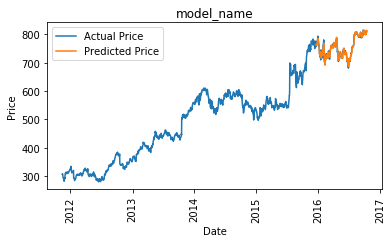

Adj Close    3.414625
dtype: float64
Adj Close    0.083412
dtype: float64
0.979870013109


In [241]:
from sklearn import linear_model
from sklearn.metrics import r2_score
import sklearn
import inspect
from sklearn.pipeline import Pipeline
check=[]
def f(n=30,n_spl=5,analyse_cv=True,poly_t=False):
    index = 1
    SEED = 100
    random_state = np.random.RandomState(SEED)
    tscv = TimeSeriesSplit(n_splits=n_spl)
    grid=fit_model(X.values,Y.values,tscv.split(X),'r',index)
    params = grid.best_params_ 
    reg ,_= regressor_dict[regressor_dict.keys()[index]]()
    reg.set_params(**params)
    #print type(reg).__name__
    if analyse_cv:
        mse=[]
        mae=[]
        r_2=[]
        
        print grid.cv_results_['mean_test_score']
        error =  grid.cv_results_['mean_test_score']
        grid_params =list(grid.cv_results_['params'])
        global check
        if len(grid_params[0].keys())>1:
            parameters = list(itertools.product(*grid_params.values()[::-1]))
        else:
            parameters =[f[grid_params[0].keys()[0]] for f in grid_params]
        plot_MSE(parameters,error)
    else:
        tscv = TimeSeriesSplit(len(X)/n)
    train_index,test_index = get_last_cv(tscv.split(X))
    X_train ,X_test= X.iloc[train_index],X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    if poly_t:
        X_train,X_test = poly_transform(X_train,X_test,2)
    reg.fit(X_train,y_train)
    prediction = reg.predict(X_test)
    #print prediction.shape
    df = pd.Series(prediction.flatten(), index=y_test.index)
    price = y_train.append(y_test)
    plot_prediction(price,df,'model_name',ticker)
    p_l = map(lambda x:[x],prediction)
    #print np.expand_dims(prediction, axis=0).shape
    if len(prediction.shape)==1:
        prediction=np.expand_dims(prediction,axis=1)
    print np.mean(abs(np.asarray(prediction)-y_test))
    print np.mean((np.asarray(prediction)-y_test))**2
    print reg.score(X_test,y_test)
    return reg
model =f(analyse_cv=True)

In [240]:
X.head()

,ema10,ema20,sma10,sma20,rsi,drr,mom,will,Volume,High,Close,ATR,MEDPRICE,MFI,OBV,ROCP,ROCR
2011-11-14,302.750433,300.739430,302.654163,299.854360,66.407127,0.007644,1.028282,0.0,0.124340,618.079979,612.999981,12.528019,612.929983,63.053353,62222400.0,0.036033,1.036033
2011-11-15,303.813074,301.512703,303.676185,300.611367,68.583899,0.005808,1.034254,0.0,0.082252,618.079979,616.560016,12.363085,614.289980,64.539849,67569000.0,0.042050,1.042050
2011-11-16,304.218522,301.957362,304.443452,300.931687,62.768608,-0.008255,1.025715,100.0,0.076710,618.300034,611.470018,12.207317,614.455006,65.730334,62357300.0,0.049896,1.049896
2011-11-17,303.584829,301.837760,304.070078,300.949957,43.617383,-0.017335,0.987737,100.0,0.149345,612.289998,600.870033,12.317406,604.535005,60.362092,55377700.0,0.017544,1.017544
2011-11-18,302.521087,301.437414,303.196204,300.818325,35.551154,-0.009969,0.971486,100.0,0.132467,604.500005,594.879996,12.265158,599.125015,59.982937,48808900.0,0.024419,1.024419


In [112]:
len(X)/60

24

In [84]:
check

[{'max_features': 'auto', 'n_estimators': 10},
 {'max_features': 'auto', 'n_estimators': 20},
 {'max_features': 'auto', 'n_estimators': 30},
 {'max_features': 'auto', 'n_estimators': 40},
 {'max_features': 'auto', 'n_estimators': 50},
 {'max_features': 'auto', 'n_estimators': 60},
 {'max_features': 'auto', 'n_estimators': 70},
 {'max_features': 'auto', 'n_estimators': 80},
 {'max_features': 'auto', 'n_estimators': 90},
 {'max_features': 'auto', 'n_estimators': 100},
 {'max_features': 'auto', 'n_estimators': 110},
 {'max_features': 'auto', 'n_estimators': 120},
 {'max_features': 'auto', 'n_estimators': 130},
 {'max_features': 'auto', 'n_estimators': 140},
 {'max_features': 'auto', 'n_estimators': 150},
 {'max_features': 'auto', 'n_estimators': 160},
 {'max_features': 'auto', 'n_estimators': 170},
 {'max_features': 'log2', 'n_estimators': 10},
 {'max_features': 'log2', 'n_estimators': 20},
 {'max_features': 'log2', 'n_estimators': 30},
 {'max_features': 'log2', 'n_estimators': 40},
 {'ma

In [85]:
X_test =X.ix[-50:, ]
X_train = X.ix[0:-50, ]
y_train = Y.ix[-50:]
y_test = Y.ix[0:50,]
reg=model
print prediction.shape
df = pd.Series(prediction.flatten(), index=y_test.index)
price = y_train.append(y_test)
plot_prediction(price,df,'model_name',ticker)
p_l = map(lambda x:[x],prediction)
print np.expand_dims(prediction, axis=0).shape
if len(prediction.shape)==1:
    prediction=np.expand_dims(prediction,axis=1)
print np.mean(abs(np.asarray(prediction)-y_test))
print np.mean((np.asarray(prediction)-y_test))**2
print reg.score(X_test,y_test)

NameError: name 'prediction' is not defined

In [135]:

from collections import deque
tscv = TimeSeriesSplit(n_splits=5)
aa = tscv.split(X)
print type(aa)

print X


<type 'generator'>
                 ema10       ema20       sma10       sma20         rsi  \
2010-11-12  309.379980  308.961587  311.043043  309.535038   32.236738   
2010-11-15  305.302025  306.694005  307.665669  308.394398    5.122818   
2010-11-16  302.909010  305.266074  305.595600  307.574828    3.777425   
2010-11-17  300.936312  303.973824  303.517023  306.698202    3.763127   
2010-11-18  300.507379  303.447007  302.005012  306.269273   23.137107   
2010-11-19  299.634835  302.693413  300.303812  305.696951   21.679723   
2010-11-22  297.895019  300.870821  296.776289  303.909666   34.473861   
2010-11-23  296.786007  299.993518  295.761271  302.979485   28.462140   
2010-11-24  296.967271  299.780086  295.344853  302.246252   42.953899   
2010-11-26  296.784568  299.174153  295.634141  300.614871   57.065670   
2010-11-29  295.392900  297.780591  295.192195  297.748003   36.953888   
2010-11-30  292.254596  295.895425  293.434437  296.067074   20.645274   
2010-12-01  290.473

In [150]:
ESTIMATORS = {
    "Lasso" :linear_model.LassoCV(),
    "Ridge": linear_model.RidgeCV(),
    "ElasticNet":linear_model.ElasticNetCV(),
    "Linear":linear_model.LinearRegression()
}


def fit_gridModel(X,Y,r='ElasticNet'):
    lasso = ESTIMATORS[r]
    return lasso.fit(X,Y)
    

[('MSE', <function Regressors.MSE>),
 ('adaboost_regressor', <function Regressors.adaboost_regressor>),
 ('elasticnet_regressor', <function Regressors.elasticnet_regressor>),
 ('lasso_regressor', <function Regressors.lasso_regressor>),
 ('linear_regressor', <function Regressors.linear_regressor>),
 ('poly_regressor', <function Regressors.poly_regressor>),
 ('randomforest_regressor', <function Regressors.randomforest_regressor>),
 ('ridge_regressor', <function Regressors.ridge_regressor>),
 ('svm_regressor', <function Regressors.svm_regressor>)]

In [514]:
np.logspace(0,10,num=1e-5, base=10, endpoint=False)

array([], dtype=float64)

In [661]:
X.to_csv('X.csv', sep='\t')
Y.to_csv('y.csv',sep='\t')

In [663]:
X.head()

,ema10,ema20,sma10,sma20,rsi,drr,mom,will,Volume,High,Close,ATR,MEDPRICE,MFI,OBV,ROCP,ROCR
Date,,,,,,,,,,,,,,,,,
2006-11-13,237.543053,236.279213,237.358859,237.785288,70.303515,0.015796,1.019563,0.0,0.056723,481.169996,481.030000,9.858156,477.655006,61.962083,57016700.0,0.125743,1.125743
2006-11-14,238.881534,237.131088,238.234735,237.852855,78.225772,0.017192,1.037092,0.0,0.181859,489.949996,489.300011,9.844550,485.225005,63.865399,71449000.0,0.145097,1.145097
2006-11-15,240.215656,238.025632,239.242243,238.023776,79.928598,0.005375,1.042666,0.0,0.231684,499.849998,491.930008,9.868065,495.890003,67.539825,88173600.0,0.166402,1.166402
2006-11-16,241.668321,239.024524,240.190691,238.541794,79.198730,0.008070,1.039732,0.0,0.089324,497.680020,495.900003,9.730796,495.120007,70.693292,98348600.0,0.178918,1.178918
2006-11-17,243.119619,240.064288,241.503003,239.132134,92.344951,0.005828,1.055484,0.0,0.107493,499.660003,498.789993,9.628436,496.330008,70.777249,109359500.0,0.189549,1.189549
